In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 100 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [3]:
Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnected(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

Train on 800 samples, validate on 200 samples
Epoch 1/1000
410/800 [==============>...............] - ETA: 0s - loss: 7.3417e-04 - mae: 0.0218

2023-07-03 19:54:25.524006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-07-03 19:54:25.524068: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)



Epoch 1: val_loss improved from inf to 0.00056, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 333us/sample - loss: 6.0848e-04 - mae: 0.0202 - val_loss: 5.5585e-04 - val_mae: 0.0204
Epoch 2/1000
390/800 [=============>................] - ETA: 0s - loss: 4.6314e-04 - mae: 0.0181
Epoch 2: val_loss improved from 0.00056 to 0.00051, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 180us/sample - loss: 4.8160e-04 - mae: 0.0185 - val_loss: 5.0896e-04 - val_mae: 0.0196
Epoch 3/1000
710/800 [=========================>....] - ETA: 0s - loss: 4.4980e-04 - mae: 0.0180
Epoch 3: val_loss improved from 0.00051 to 0.00045, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 197us/sample - loss: 4.4166e-04 - mae: 0.0178 - val_loss: 4.4736e-04 - val_mae: 0.0178
Epoch 4/1000
440/800 [===============>..............] - ETA: 0s - loss: 4.4318e-04 - mae: 0.

Epoch 26/1000
760/800 [===========================>..] - ETA: 0s - loss: 5.8370e-05 - mae: 0.0060
Epoch 26: val_loss improved from 0.00011 to 0.00011, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 186us/sample - loss: 5.8497e-05 - mae: 0.0061 - val_loss: 1.0770e-04 - val_mae: 0.0084
Epoch 27/1000
730/800 [==========================>...] - ETA: 0s - loss: 5.5634e-05 - mae: 0.0059
Epoch 27: val_loss improved from 0.00011 to 0.00011, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 193us/sample - loss: 5.4530e-05 - mae: 0.0059 - val_loss: 1.0509e-04 - val_mae: 0.0080
Epoch 28/1000
740/800 [==========================>...] - ETA: 0s - loss: 4.7780e-05 - mae: 0.0055
Epoch 28: val_loss improved from 0.00011 to 0.00010, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 187us/sample - loss: 4.7624e-05 - mae: 0.0055 - val_loss: 9.9270e-05 - va

Epoch 52/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.9946e-05 - mae: 0.0036
Epoch 52: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 2.0081e-05 - mae: 0.0036 - val_loss: 4.1109e-05 - val_mae: 0.0051
Epoch 53/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9599e-05 - mae: 0.0036
Epoch 53: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 165us/sample - loss: 2.0031e-05 - mae: 0.0036 - val_loss: 3.7576e-05 - val_mae: 0.0049
Epoch 54/1000
720/800 [==========================>...] - ETA: 0s - loss: 2.0337e-05 - mae: 0.0036
Epoch 54: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 2.0499e-05 - mae: 0.0036 - val_loss: 3.7712e-05 - val_mae: 0.0049
Epoch 55/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.0600e-05 - mae: 0.0036
Epoch 

Epoch 80/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8858e-05 - mae: 0.0035
Epoch 80: val_loss improved from 0.00003 to 0.00003, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 160us/sample - loss: 1.8563e-05 - mae: 0.0034 - val_loss: 3.4241e-05 - val_mae: 0.0046
Epoch 81/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9706e-05 - mae: 0.0035
Epoch 81: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 148us/sample - loss: 1.8364e-05 - mae: 0.0034 - val_loss: 3.8222e-05 - val_mae: 0.0050
Epoch 82/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.0561e-05 - mae: 0.0037
Epoch 82: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 139us/sample - loss: 1.9570e-05 - mae: 0.0036 - val_loss: 3.5819e-05 - val_mae: 0.0047
Epoch 83/1000
460/800 [================>.............] - ETA: 0s - loss: 1.9089e-05 - mae: 0.0035
Epoch 

Epoch 109/1000
800/800 [==============================] - ETA: 0s - loss: 1.8697e-05 - mae: 0.0035
Epoch 109: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 155us/sample - loss: 1.8697e-05 - mae: 0.0035 - val_loss: 3.9245e-05 - val_mae: 0.0048
Epoch 110/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.9328e-05 - mae: 0.0035
Epoch 110: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 159us/sample - loss: 1.9408e-05 - mae: 0.0035 - val_loss: 3.5712e-05 - val_mae: 0.0048
Epoch 111/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8094e-05 - mae: 0.0034
Epoch 111: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 138us/sample - loss: 1.7896e-05 - mae: 0.0033 - val_loss: 3.4372e-05 - val_mae: 0.0046
Epoch 112/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6957e-05 - mae: 0.0033
Epoch 112: val_loss did not improve from 0.00003
800/800 [

440/800 [===============>..............] - ETA: 0s - loss: 2.1865e-05 - mae: 0.0037
Epoch 138: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 136us/sample - loss: 2.3911e-05 - mae: 0.0039 - val_loss: 3.7266e-05 - val_mae: 0.0047
Epoch 139/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7684e-05 - mae: 0.0034
Epoch 139: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 135us/sample - loss: 1.7640e-05 - mae: 0.0034 - val_loss: 3.8519e-05 - val_mae: 0.0048
Epoch 140/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.1648e-05 - mae: 0.0037
Epoch 140: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 140us/sample - loss: 2.0772e-05 - mae: 0.0036 - val_loss: 3.5938e-05 - val_mae: 0.0046
Epoch 141/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8796e-05 - mae: 0.0034
Epoch 141: val_loss did not improve from 0.00003
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.7055e-05 - mae: 0.0033
Epoch 167: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 1.7153e-05 - mae: 0.0033 - val_loss: 3.4380e-05 - val_mae: 0.0046
Epoch 168/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6319e-05 - mae: 0.0032
Epoch 168: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 136us/sample - loss: 1.7355e-05 - mae: 0.0033 - val_loss: 4.9686e-05 - val_mae: 0.0058
Epoch 169/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9498e-05 - mae: 0.0035
Epoch 169: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 138us/sample - loss: 1.9558e-05 - mae: 0.0035 - val_loss: 3.5833e-05 - val_mae: 0.0048
Epoch 170/1000
470/800 [================>.............] - ETA: 0s - loss: 1.6620e-05 - mae: 0.0033
Epoch 170: val_loss did not improve from 0.00003
800/800 [===============

550/800 [===================>..........] - ETA: 0s - loss: 1.8011e-05 - mae: 0.0033
Epoch 196: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 109us/sample - loss: 1.7926e-05 - mae: 0.0033 - val_loss: 3.5556e-05 - val_mae: 0.0046
Epoch 197/1000
540/800 [===================>..........] - ETA: 0s - loss: 2.0805e-05 - mae: 0.0037
Epoch 197: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 112us/sample - loss: 1.9757e-05 - mae: 0.0036 - val_loss: 3.5583e-05 - val_mae: 0.0046
Epoch 198/1000
500/800 [=================>............] - ETA: 0s - loss: 1.7976e-05 - mae: 0.0033
Epoch 198: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 118us/sample - loss: 1.7575e-05 - mae: 0.0033 - val_loss: 3.5988e-05 - val_mae: 0.0048
Epoch 199/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.6633e-05 - mae: 0.0033
Epoch 199: val_loss did not improve from 0.00003
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.6831e-05 - mae: 0.0033
Epoch 225: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 143us/sample - loss: 1.8107e-05 - mae: 0.0033 - val_loss: 3.5057e-05 - val_mae: 0.0047
Epoch 226/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.6962e-05 - mae: 0.0033
Epoch 226: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 159us/sample - loss: 1.7113e-05 - mae: 0.0033 - val_loss: 4.2496e-05 - val_mae: 0.0053
Epoch 227/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8579e-05 - mae: 0.0033
Epoch 227: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 1.8955e-05 - mae: 0.0034 - val_loss: 3.5903e-05 - val_mae: 0.0047
Epoch 228/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5531e-05 - mae: 0.0031
Epoch 228: val_loss did not improve from 0.00003
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 2.3431e-05 - mae: 0.0039
Epoch 254: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 131us/sample - loss: 2.0741e-05 - mae: 0.0036 - val_loss: 3.7516e-05 - val_mae: 0.0048
Epoch 255/1000
470/800 [================>.............] - ETA: 0s - loss: 1.5579e-05 - mae: 0.0032
Epoch 255: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 132us/sample - loss: 1.6194e-05 - mae: 0.0032 - val_loss: 3.6966e-05 - val_mae: 0.0048
Epoch 256/1000
470/800 [================>.............] - ETA: 0s - loss: 1.8147e-05 - mae: 0.0034
Epoch 256: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 127us/sample - loss: 1.9442e-05 - mae: 0.0035 - val_loss: 3.5657e-05 - val_mae: 0.0047
Epoch 257/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6146e-05 - mae: 0.0032
Epoch 257: val_loss did not improve from 0.00003
800/800 [===============

490/800 [=================>............] - ETA: 0s - loss: 1.5165e-05 - mae: 0.0031
Epoch 283: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 127us/sample - loss: 1.6112e-05 - mae: 0.0032 - val_loss: 3.6303e-05 - val_mae: 0.0048
Epoch 284/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.4900e-05 - mae: 0.0031
Epoch 284: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 135us/sample - loss: 1.7711e-05 - mae: 0.0033 - val_loss: 3.6499e-05 - val_mae: 0.0048
Epoch 285/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7088e-05 - mae: 0.0033
Epoch 285: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 129us/sample - loss: 2.0388e-05 - mae: 0.0036 - val_loss: 5.5297e-05 - val_mae: 0.0059
Epoch 286/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.8050e-05 - mae: 0.0034
Epoch 286: val_loss did not improve from 0.00003
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 1.7575e-05 - mae: 0.0033
Epoch 312: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 154us/sample - loss: 1.7701e-05 - mae: 0.0033 - val_loss: 3.7314e-05 - val_mae: 0.0049
Epoch 313/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.4965e-05 - mae: 0.0030
Epoch 313: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 135us/sample - loss: 1.5459e-05 - mae: 0.0031 - val_loss: 3.7382e-05 - val_mae: 0.0048
Epoch 314/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6778e-05 - mae: 0.0032
Epoch 314: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 131us/sample - loss: 1.7001e-05 - mae: 0.0033 - val_loss: 4.2819e-05 - val_mae: 0.0053
Epoch 315/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7849e-05 - mae: 0.0033
Epoch 315: val_loss did not improve from 0.00003
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.6436e-05 - mae: 0.0032
Epoch 341: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 136us/sample - loss: 1.8362e-05 - mae: 0.0034 - val_loss: 3.7459e-05 - val_mae: 0.0048
Epoch 342/1000
460/800 [================>.............] - ETA: 0s - loss: 2.8688e-05 - mae: 0.0043
Epoch 342: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 130us/sample - loss: 2.3947e-05 - mae: 0.0039 - val_loss: 4.0309e-05 - val_mae: 0.0049
Epoch 343/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6853e-05 - mae: 0.0033
Epoch 343: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 131us/sample - loss: 1.7280e-05 - mae: 0.0033 - val_loss: 3.6817e-05 - val_mae: 0.0048
Epoch 344/1000
470/800 [================>.............] - ETA: 0s - loss: 1.7190e-05 - mae: 0.0033
Epoch 344: val_loss did not improve from 0.00003
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 2.1369e-05 - mae: 0.0037
Epoch 370: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 136us/sample - loss: 1.9854e-05 - mae: 0.0036 - val_loss: 3.7641e-05 - val_mae: 0.0048
Epoch 371/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.5324e-05 - mae: 0.0031
Epoch 371: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 130us/sample - loss: 1.7050e-05 - mae: 0.0033 - val_loss: 4.4350e-05 - val_mae: 0.0054
Epoch 372/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.0968e-05 - mae: 0.0036
Epoch 372: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 139us/sample - loss: 2.0994e-05 - mae: 0.0036 - val_loss: 5.9168e-05 - val_mae: 0.0063
Epoch 373/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5537e-05 - mae: 0.0031
Epoch 373: val_loss did not improve from 0.00003
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.4076e-05 - mae: 0.0030
Epoch 399: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 142us/sample - loss: 1.4938e-05 - mae: 0.0030 - val_loss: 3.7292e-05 - val_mae: 0.0048
Epoch 400/1000
480/800 [=================>............] - ETA: 0s - loss: 1.5835e-05 - mae: 0.0032
Epoch 400: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 125us/sample - loss: 1.6117e-05 - mae: 0.0032 - val_loss: 3.7934e-05 - val_mae: 0.0049
Epoch 401/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.4772e-05 - mae: 0.0030
Epoch 401: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 136us/sample - loss: 1.5003e-05 - mae: 0.0030 - val_loss: 3.7492e-05 - val_mae: 0.0048
Epoch 402/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.4565e-05 - mae: 0.0031
Epoch 402: val_loss did not improve from 0.00003
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 2.0621e-05 - mae: 0.0037
Epoch 428: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 147us/sample - loss: 1.9138e-05 - mae: 0.0035 - val_loss: 3.8220e-05 - val_mae: 0.0049
Epoch 429/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.5260e-05 - mae: 0.0031
Epoch 429: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 169us/sample - loss: 1.5639e-05 - mae: 0.0031 - val_loss: 3.9584e-05 - val_mae: 0.0050
Epoch 430/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.6556e-05 - mae: 0.0032
Epoch 430: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 169us/sample - loss: 1.7166e-05 - mae: 0.0033 - val_loss: 4.1747e-05 - val_mae: 0.0052
Epoch 431/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.6738e-05 - mae: 0.0032
Epoch 431: val_loss did not improve from 0.00003
800/800 [===============

690/800 [========================>.....] - ETA: 0s - loss: 1.4632e-05 - mae: 0.0030
Epoch 457: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 172us/sample - loss: 1.5256e-05 - mae: 0.0031 - val_loss: 3.9286e-05 - val_mae: 0.0050
Epoch 458/1000
790/800 [============================>.] - ETA: 0s - loss: 1.9810e-05 - mae: 0.0035
Epoch 458: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 152us/sample - loss: 1.9780e-05 - mae: 0.0035 - val_loss: 4.0805e-05 - val_mae: 0.0051
Epoch 459/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5157e-05 - mae: 0.0031
Epoch 459: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 147us/sample - loss: 1.6516e-05 - mae: 0.0032 - val_loss: 3.8933e-05 - val_mae: 0.0049
Epoch 460/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6179e-05 - mae: 0.0032
Epoch 460: val_loss did not improve from 0.00003
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.6240e-05 - mae: 0.0032
Epoch 486: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 145us/sample - loss: 1.6274e-05 - mae: 0.0032 - val_loss: 3.8882e-05 - val_mae: 0.0049
Epoch 487/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.6306e-05 - mae: 0.0032
Epoch 487: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 165us/sample - loss: 1.6266e-05 - mae: 0.0032 - val_loss: 3.9048e-05 - val_mae: 0.0050
Epoch 488/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.5703e-05 - mae: 0.0031
Epoch 488: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 174us/sample - loss: 1.5271e-05 - mae: 0.0031 - val_loss: 4.2593e-05 - val_mae: 0.0052
Epoch 489/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8547e-05 - mae: 0.0034
Epoch 489: val_loss did not improve from 0.00003
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.5929e-05 - mae: 0.0031
Epoch 515: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 130us/sample - loss: 1.5663e-05 - mae: 0.0031 - val_loss: 3.9355e-05 - val_mae: 0.0050
Epoch 516/1000
480/800 [=================>............] - ETA: 0s - loss: 1.5099e-05 - mae: 0.0030
Epoch 516: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 128us/sample - loss: 1.6792e-05 - mae: 0.0032 - val_loss: 4.0375e-05 - val_mae: 0.0051
Epoch 517/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5873e-05 - mae: 0.0031
Epoch 517: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 133us/sample - loss: 1.6313e-05 - mae: 0.0032 - val_loss: 4.0926e-05 - val_mae: 0.0051
Epoch 518/1000
480/800 [=================>............] - ETA: 0s - loss: 1.6450e-05 - mae: 0.0032
Epoch 518: val_loss did not improve from 0.00003
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.6830e-05 - mae: 0.0032
Epoch 544: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 127us/sample - loss: 1.6234e-05 - mae: 0.0032 - val_loss: 4.0880e-05 - val_mae: 0.0051
Epoch 545/1000
380/800 [=============>................] - ETA: 0s - loss: 1.7211e-05 - mae: 0.0033
Epoch 545: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 147us/sample - loss: 1.7707e-05 - mae: 0.0033 - val_loss: 4.0238e-05 - val_mae: 0.0051
Epoch 546/1000
800/800 [==============================] - ETA: 0s - loss: 1.5272e-05 - mae: 0.0031
Epoch 546: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 149us/sample - loss: 1.5272e-05 - mae: 0.0031 - val_loss: 4.7802e-05 - val_mae: 0.0056
Epoch 547/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6527e-05 - mae: 0.0033
Epoch 547: val_loss did not improve from 0.00003
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.5985e-05 - mae: 0.0031
Epoch 573: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 153us/sample - loss: 1.5985e-05 - mae: 0.0031 - val_loss: 3.9642e-05 - val_mae: 0.0050
Epoch 574/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.5121e-05 - mae: 0.0031
Epoch 574: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 147us/sample - loss: 1.5169e-05 - mae: 0.0031 - val_loss: 3.9553e-05 - val_mae: 0.0050
Epoch 575/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.4808e-05 - mae: 0.0031
Epoch 575: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 143us/sample - loss: 1.6113e-05 - mae: 0.0032 - val_loss: 4.3861e-05 - val_mae: 0.0052
Epoch 576/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.4763e-05 - mae: 0.0030
Epoch 576: val_loss did not improve from 0.00003
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7357e-05 - mae: 0.0032   
Epoch 602: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 153us/sample - loss: 1.7373e-05 - mae: 0.0032 - val_loss: 3.9850e-05 - val_mae: 0.0050
Epoch 603/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.2483e-05 - mae: 0.0028
Epoch 603: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 146us/sample - loss: 1.4051e-05 - mae: 0.0029 - val_loss: 4.1084e-05 - val_mae: 0.0052
Epoch 604/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.3941e-05 - mae: 0.0029
Epoch 604: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 143us/sample - loss: 1.5008e-05 - mae: 0.0030 - val_loss: 4.1667e-05 - val_mae: 0.0052
Epoch 605/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.5123e-05 - mae: 0.0031
Epoch 605: val_loss did not improve from 0.00003
800/800 [============

670/800 [========================>.....] - ETA: 0s - loss: 1.4413e-05 - mae: 0.0029
Epoch 631: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 180us/sample - loss: 1.4432e-05 - mae: 0.0030 - val_loss: 4.2271e-05 - val_mae: 0.0052
Epoch 632/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.4573e-05 - mae: 0.0030
Epoch 632: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 169us/sample - loss: 1.4687e-05 - mae: 0.0030 - val_loss: 4.0459e-05 - val_mae: 0.0051
Epoch 633/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.4795e-05 - mae: 0.0030
Epoch 633: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 168us/sample - loss: 1.4899e-05 - mae: 0.0031 - val_loss: 4.1241e-05 - val_mae: 0.0050
Epoch 634/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.4854e-05 - mae: 0.0030
Epoch 634: val_loss did not improve from 0.00003
800/800 [===============

640/800 [=======================>......] - ETA: 0s - loss: 1.5460e-05 - mae: 0.0031
Epoch 660: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 183us/sample - loss: 1.5553e-05 - mae: 0.0031 - val_loss: 4.2865e-05 - val_mae: 0.0053
Epoch 661/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.4701e-05 - mae: 0.0030
Epoch 661: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 166us/sample - loss: 1.4955e-05 - mae: 0.0030 - val_loss: 4.1663e-05 - val_mae: 0.0051
Epoch 662/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.5761e-05 - mae: 0.0032
Epoch 662: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 168us/sample - loss: 1.5739e-05 - mae: 0.0032 - val_loss: 4.1850e-05 - val_mae: 0.0051
Epoch 663/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.5624e-05 - mae: 0.0031
Epoch 663: val_loss did not improve from 0.00003
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.5072e-05 - mae: 0.0030
Epoch 689: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 150us/sample - loss: 1.5072e-05 - mae: 0.0030 - val_loss: 4.5977e-05 - val_mae: 0.0053
Epoch 690/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5529e-05 - mae: 0.0031
Epoch 690: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 137us/sample - loss: 1.7398e-05 - mae: 0.0033 - val_loss: 4.3312e-05 - val_mae: 0.0051
Epoch 691/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6212e-05 - mae: 0.0032
Epoch 691: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 153us/sample - loss: 1.6433e-05 - mae: 0.0032 - val_loss: 6.1186e-05 - val_mae: 0.0064
Epoch 692/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8041e-05 - mae: 0.0034
Epoch 692: val_loss did not improve from 0.00003
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.4953e-05 - mae: 0.0030
Epoch 718: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 138us/sample - loss: 1.4874e-05 - mae: 0.0030 - val_loss: 4.0313e-05 - val_mae: 0.0050
Epoch 719/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8035e-05 - mae: 0.0034
Epoch 719: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 145us/sample - loss: 1.9157e-05 - mae: 0.0035 - val_loss: 4.0609e-05 - val_mae: 0.0051
Epoch 720/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7655e-05 - mae: 0.0034
Epoch 720: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 137us/sample - loss: 1.7762e-05 - mae: 0.0033 - val_loss: 4.0392e-05 - val_mae: 0.0051
Epoch 721/1000
470/800 [================>.............] - ETA: 0s - loss: 1.7917e-05 - mae: 0.0033
Epoch 721: val_loss did not improve from 0.00003
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.4453e-05 - mae: 0.0030
Epoch 747: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 136us/sample - loss: 1.5424e-05 - mae: 0.0031 - val_loss: 4.0082e-05 - val_mae: 0.0050
Epoch 748/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6103e-05 - mae: 0.0031
Epoch 748: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 138us/sample - loss: 1.4864e-05 - mae: 0.0030 - val_loss: 4.1294e-05 - val_mae: 0.0050
Epoch 749/1000
460/800 [================>.............] - ETA: 0s - loss: 1.3572e-05 - mae: 0.0029
Epoch 749: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 129us/sample - loss: 1.4935e-05 - mae: 0.0031 - val_loss: 5.4388e-05 - val_mae: 0.0060
Epoch 750/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.1725e-05 - mae: 0.0038
Epoch 750: val_loss did not improve from 0.00003
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.4862e-05 - mae: 0.0030
Epoch 776: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 135us/sample - loss: 1.6123e-05 - mae: 0.0031 - val_loss: 4.0866e-05 - val_mae: 0.0051
Epoch 777/1000
470/800 [================>.............] - ETA: 0s - loss: 1.5374e-05 - mae: 0.0030
Epoch 777: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 132us/sample - loss: 1.6182e-05 - mae: 0.0031 - val_loss: 4.1095e-05 - val_mae: 0.0051
Epoch 778/1000
480/800 [=================>............] - ETA: 0s - loss: 1.3939e-05 - mae: 0.0029
Epoch 778: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 129us/sample - loss: 1.4985e-05 - mae: 0.0030 - val_loss: 4.2925e-05 - val_mae: 0.0053
Epoch 779/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.4209e-05 - mae: 0.0030
Epoch 779: val_loss did not improve from 0.00003
800/800 [===============

770/800 [===========================>..] - ETA: 0s - loss: 1.6025e-05 - mae: 0.0031
Epoch 805: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 153us/sample - loss: 1.6077e-05 - mae: 0.0031 - val_loss: 4.1195e-05 - val_mae: 0.0051
Epoch 806/1000
380/800 [=============>................] - ETA: 0s - loss: 1.4857e-05 - mae: 0.0030
Epoch 806: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 144us/sample - loss: 1.5179e-05 - mae: 0.0030 - val_loss: 4.7833e-05 - val_mae: 0.0056
Epoch 807/1000
460/800 [================>.............] - ETA: 0s - loss: 1.1911e-05 - mae: 0.0027
Epoch 807: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 131us/sample - loss: 1.4023e-05 - mae: 0.0029 - val_loss: 4.5158e-05 - val_mae: 0.0054
Epoch 808/1000
490/800 [=================>............] - ETA: 0s - loss: 1.5067e-05 - mae: 0.0030
Epoch 808: val_loss did not improve from 0.00003
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.6562e-05 - mae: 0.0032
Epoch 834: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 134us/sample - loss: 1.5930e-05 - mae: 0.0031 - val_loss: 5.2078e-05 - val_mae: 0.0058
Epoch 835/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.3998e-05 - mae: 0.0029
Epoch 835: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 144us/sample - loss: 1.5556e-05 - mae: 0.0031 - val_loss: 4.0683e-05 - val_mae: 0.0051
Epoch 836/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.4259e-05 - mae: 0.0030
Epoch 836: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 142us/sample - loss: 1.4864e-05 - mae: 0.0030 - val_loss: 4.0521e-05 - val_mae: 0.0051
Epoch 837/1000
780/800 [============================>.] - ETA: 0s - loss: 1.4588e-05 - mae: 0.0030
Epoch 837: val_loss did not improve from 0.00003
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.4416e-05 - mae: 0.0030
Epoch 863: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 1.5157e-05 - mae: 0.0030 - val_loss: 4.1989e-05 - val_mae: 0.0051
Epoch 864/1000
790/800 [============================>.] - ETA: 0s - loss: 1.4038e-05 - mae: 0.0029
Epoch 864: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 156us/sample - loss: 1.4237e-05 - mae: 0.0030 - val_loss: 4.2158e-05 - val_mae: 0.0051
Epoch 865/1000
800/800 [==============================] - ETA: 0s - loss: 1.4670e-05 - mae: 0.0030
Epoch 865: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 149us/sample - loss: 1.4670e-05 - mae: 0.0030 - val_loss: 4.0946e-05 - val_mae: 0.0051
Epoch 866/1000
480/800 [=================>............] - ETA: 0s - loss: 1.5077e-05 - mae: 0.0031
Epoch 866: val_loss did not improve from 0.00003
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.6131e-05 - mae: 0.0032
Epoch 892: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 132us/sample - loss: 1.7837e-05 - mae: 0.0034 - val_loss: 4.9385e-05 - val_mae: 0.0055
Epoch 893/1000
470/800 [================>.............] - ETA: 0s - loss: 1.5734e-05 - mae: 0.0031
Epoch 893: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 132us/sample - loss: 1.5610e-05 - mae: 0.0031 - val_loss: 4.0749e-05 - val_mae: 0.0051
Epoch 894/1000
490/800 [=================>............] - ETA: 0s - loss: 1.4560e-05 - mae: 0.0030
Epoch 894: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 126us/sample - loss: 1.3966e-05 - mae: 0.0029 - val_loss: 4.6361e-05 - val_mae: 0.0053
Epoch 895/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6259e-05 - mae: 0.0032
Epoch 895: val_loss did not improve from 0.00003
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.4597e-05 - mae: 0.0029
Epoch 921: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 146us/sample - loss: 1.5052e-05 - mae: 0.0030 - val_loss: 4.1165e-05 - val_mae: 0.0051
Epoch 922/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.4827e-05 - mae: 0.0030
Epoch 922: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 146us/sample - loss: 1.4711e-05 - mae: 0.0030 - val_loss: 4.1950e-05 - val_mae: 0.0051
Epoch 923/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.4834e-05 - mae: 0.0030
Epoch 923: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 144us/sample - loss: 1.4462e-05 - mae: 0.0029 - val_loss: 4.4747e-05 - val_mae: 0.0054
Epoch 924/1000
460/800 [================>.............] - ETA: 0s - loss: 1.3492e-05 - mae: 0.0028
Epoch 924: val_loss did not improve from 0.00003
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.6341e-05 - mae: 0.0032
Epoch 950: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 1.5940e-05 - mae: 0.0031 - val_loss: 4.2505e-05 - val_mae: 0.0051
Epoch 951/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5176e-05 - mae: 0.0030
Epoch 951: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 137us/sample - loss: 1.4667e-05 - mae: 0.0030 - val_loss: 4.5073e-05 - val_mae: 0.0054
Epoch 952/1000
460/800 [================>.............] - ETA: 0s - loss: 1.4311e-05 - mae: 0.0030
Epoch 952: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 128us/sample - loss: 1.5673e-05 - mae: 0.0031 - val_loss: 4.3083e-05 - val_mae: 0.0052
Epoch 953/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.5679e-05 - mae: 0.0032
Epoch 953: val_loss did not improve from 0.00003
800/800 [===============

710/800 [=========================>....] - ETA: 0s - loss: 1.5282e-05 - mae: 0.0030
Epoch 979: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 172us/sample - loss: 1.5171e-05 - mae: 0.0030 - val_loss: 5.2469e-05 - val_mae: 0.0059
Epoch 980/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.6426e-05 - mae: 0.0032
Epoch 980: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 177us/sample - loss: 1.6694e-05 - mae: 0.0032 - val_loss: 4.2497e-05 - val_mae: 0.0052
Epoch 981/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.4865e-05 - mae: 0.0030
Epoch 981: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 169us/sample - loss: 1.4848e-05 - mae: 0.0030 - val_loss: 4.1137e-05 - val_mae: 0.0051
Epoch 982/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.5191e-05 - mae: 0.0030
Epoch 982: val_loss did not improve from 0.00003
800/800 [===============

In [4]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.001}
X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'letzgus', M_samples[:2], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[1])

(array([[-3.2773125e-05]], dtype=float32),
 array([[-1.9697356e-05]], dtype=float32))

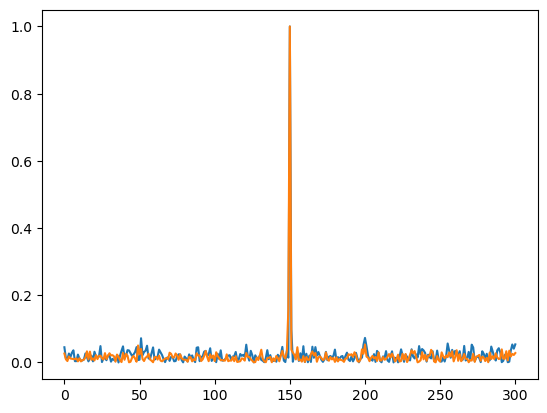

In [5]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [6]:
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.001}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

(array([[-3.2773125e-05]], dtype=float32),
 array([[-2.9371935e-05]], dtype=float32))

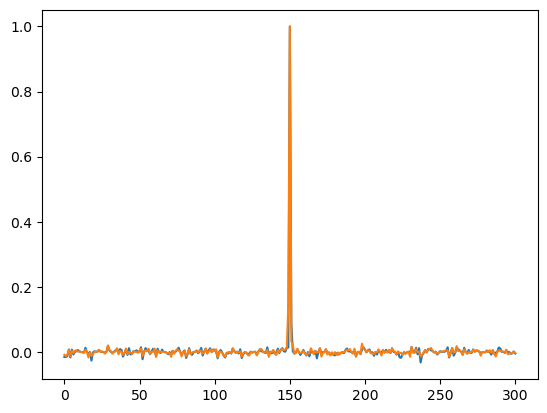

In [7]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [8]:
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.0004}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

(array([[-5.056031e-05]], dtype=float32),
 array([[-4.783942e-06]], dtype=float32))

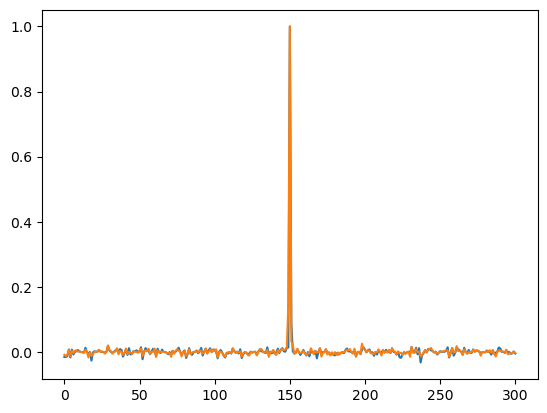

In [9]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [10]:
### Try one model with non-zero last layer bias

Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': True}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnected(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

Train on 800 samples, validate on 200 samples
Epoch 1/1000
370/800 [============>.................] - ETA: 0s - loss: 9.3973e-04 - mae: 0.0242
Epoch 1: val_loss improved from inf to 0.00052, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 316us/sample - loss: 6.9473e-04 - mae: 0.0213 - val_loss: 5.1573e-04 - val_mae: 0.0198
Epoch 2/1000
410/800 [==============>...............] - ETA: 0s - loss: 4.9739e-04 - mae: 0.0191
Epoch 2: val_loss improved from 0.00052 to 0.00050, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 172us/sample - loss: 4.8557e-04 - mae: 0.0187 - val_loss: 4.9853e-04 - val_mae: 0.0194
Epoch 3/1000
420/800 [==============>...............] - ETA: 0s - loss: 4.4416e-04 - mae: 0.0179
Epoch 3: val_loss improved from 0.00050 to 0.00048, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 157us/sample - loss: 4.5665e-04 - mae

800/800 [==============================] - 0s 188us/sample - loss: 9.3431e-05 - mae: 0.0077 - val_loss: 1.7154e-04 - val_mae: 0.0105
Epoch 26/1000
700/800 [=========================>....] - ETA: 0s - loss: 8.5872e-05 - mae: 0.0074
Epoch 26: val_loss improved from 0.00017 to 0.00016, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 204us/sample - loss: 8.7360e-05 - mae: 0.0074 - val_loss: 1.6290e-04 - val_mae: 0.0101
Epoch 27/1000
780/800 [============================>.] - ETA: 0s - loss: 7.6800e-05 - mae: 0.0070
Epoch 27: val_loss improved from 0.00016 to 0.00016, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 181us/sample - loss: 7.6437e-05 - mae: 0.0070 - val_loss: 1.5761e-04 - val_mae: 0.0098
Epoch 28/1000
730/800 [==========================>...] - ETA: 0s - loss: 7.1954e-05 - mae: 0.0068
Epoch 28: val_loss improved from 0.00016 to 0.00014, saving model to /home/shreyas/XAIRT/exam

Epoch 51/1000
400/800 [==============>...............] - ETA: 0s - loss: 2.4449e-05 - mae: 0.0040
Epoch 51: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 2.3543e-05 - mae: 0.0039 - val_loss: 4.5272e-05 - val_mae: 0.0053
Epoch 52/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.2461e-05 - mae: 0.0038
Epoch 52: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 174us/sample - loss: 2.3074e-05 - mae: 0.0039 - val_loss: 4.3421e-05 - val_mae: 0.0053
Epoch 53/1000
780/800 [============================>.] - ETA: 0s - loss: 2.1839e-05 - mae: 0.0037
Epoch 53: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 183us/sample - loss: 2.1951e-05 - mae: 0.0037 - val_loss: 4.3399e-05 - val_mae: 0.0053
Epoch 54/1000
410/800 [==============>.......

Epoch 79/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.0984e-05 - mae: 0.0037
Epoch 79: val_loss improved from 0.00003 to 0.00003, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 165us/sample - loss: 1.9206e-05 - mae: 0.0035 - val_loss: 3.3863e-05 - val_mae: 0.0047
Epoch 80/1000
770/800 [===========================>..] - ETA: 0s - loss: 2.0657e-05 - mae: 0.0036
Epoch 80: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 156us/sample - loss: 2.0491e-05 - mae: 0.0036 - val_loss: 3.4399e-05 - val_mae: 0.0047
Epoch 81/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.8392e-05 - mae: 0.0034
Epoch 81: val_loss improved from 0.00003 to 0.00003, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 190us/sample - loss: 1.8186e-05 - mae: 0.0034 - val_loss: 3.3447e-05 - val_mae: 0.0046
Epoch 82/1000
770/800 [======================

Epoch 108/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9181e-05 - mae: 0.0036
Epoch 108: val_loss improved from 0.00003 to 0.00003, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 172us/sample - loss: 1.8514e-05 - mae: 0.0035 - val_loss: 3.2918e-05 - val_mae: 0.0045
Epoch 109/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.2050e-05 - mae: 0.0038
Epoch 109: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 2.3388e-05 - mae: 0.0039 - val_loss: 3.4111e-05 - val_mae: 0.0047
Epoch 110/1000
800/800 [==============================] - ETA: 0s - loss: 2.0133e-05 - mae: 0.0036
Epoch 110: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 150us/sample - loss: 2.0133e-05 - mae: 0.0036 - val_loss: 3.4447e-05 - val_mae: 0.0046
Epoch 111/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8800e-05 - mae: 0.0035

Epoch 137/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.9142e-05 - mae: 0.0035
Epoch 137: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 154us/sample - loss: 1.9109e-05 - mae: 0.0035 - val_loss: 4.7117e-05 - val_mae: 0.0057
Epoch 138/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6723e-05 - mae: 0.0033
Epoch 138: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 142us/sample - loss: 1.9248e-05 - mae: 0.0035 - val_loss: 3.3026e-05 - val_mae: 0.0045
Epoch 139/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.4737e-05 - mae: 0.0041
Epoch 139: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 2.1599e-05 - mae: 0.0037 - val_loss: 3.3230e-05 - val_mae: 0.0046
Epoch 140/1000
760/800 [===========================>..] - ETA: 0s - loss: 2.2779e-05 - mae: 0.0038
Epoch 140: val_loss did not improve from 0.00003
800/800 [

680/800 [========================>.....] - ETA: 0s - loss: 2.1693e-05 - mae: 0.0037
Epoch 166: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 182us/sample - loss: 2.1640e-05 - mae: 0.0037 - val_loss: 3.6563e-05 - val_mae: 0.0047
Epoch 167/1000
630/800 [======================>.......] - ETA: 0s - loss: 1.8249e-05 - mae: 0.0034
Epoch 167: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 192us/sample - loss: 1.8135e-05 - mae: 0.0034 - val_loss: 3.3814e-05 - val_mae: 0.0045
Epoch 168/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.6833e-05 - mae: 0.0033
Epoch 168: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 167us/sample - loss: 1.7347e-05 - mae: 0.0034 - val_loss: 3.4509e-05 - val_mae: 0.0046
Epoch 169/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9008e-05 - mae: 0.0034
Epoch 169: val_loss did not improve from 0.00003
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.9331e-05 - mae: 0.0035
Epoch 195: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 150us/sample - loss: 1.9331e-05 - mae: 0.0035 - val_loss: 3.3484e-05 - val_mae: 0.0046
Epoch 196/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7457e-05 - mae: 0.0033
Epoch 196: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 153us/sample - loss: 1.7418e-05 - mae: 0.0033 - val_loss: 3.4247e-05 - val_mae: 0.0047
Epoch 197/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8798e-05 - mae: 0.0034
Epoch 197: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 149us/sample - loss: 2.0078e-05 - mae: 0.0035 - val_loss: 3.4674e-05 - val_mae: 0.0046
Epoch 198/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8144e-05 - mae: 0.0034
Epoch 198: val_loss did not improve from 0.00003
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.6558e-05 - mae: 0.0033
Epoch 224: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 147us/sample - loss: 1.9279e-05 - mae: 0.0035 - val_loss: 4.5859e-05 - val_mae: 0.0056
Epoch 225/1000
790/800 [============================>.] - ETA: 0s - loss: 1.9189e-05 - mae: 0.0035
Epoch 225: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 152us/sample - loss: 1.9104e-05 - mae: 0.0035 - val_loss: 4.6454e-05 - val_mae: 0.0056
Epoch 226/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.8441e-05 - mae: 0.0034
Epoch 226: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 168us/sample - loss: 1.8836e-05 - mae: 0.0034 - val_loss: 3.3321e-05 - val_mae: 0.0045
Epoch 227/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.9397e-05 - mae: 0.0035
Epoch 227: val_loss did not improve from 0.00003
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.7501e-05 - mae: 0.0034
Epoch 253: val_loss improved from 0.00003 to 0.00003, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 186us/sample - loss: 1.8133e-05 - mae: 0.0034 - val_loss: 3.2613e-05 - val_mae: 0.0045
Epoch 254/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8853e-05 - mae: 0.0034
Epoch 254: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 167us/sample - loss: 1.8393e-05 - mae: 0.0034 - val_loss: 3.6363e-05 - val_mae: 0.0047
Epoch 255/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7153e-05 - mae: 0.0033
Epoch 255: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 154us/sample - loss: 1.7183e-05 - mae: 0.0033 - val_loss: 3.2890e-05 - val_mae: 0.0045
Epoch 256/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8306e-05 - mae: 0.0034
Epoch 256: val

Epoch 282/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.9171e-05 - mae: 0.0035
Epoch 282: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 156us/sample - loss: 1.9606e-05 - mae: 0.0035 - val_loss: 4.1529e-05 - val_mae: 0.0053
Epoch 283/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.9153e-05 - mae: 0.0035
Epoch 283: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 156us/sample - loss: 1.8993e-05 - mae: 0.0035 - val_loss: 3.5497e-05 - val_mae: 0.0048
Epoch 284/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.8492e-05 - mae: 0.0034
Epoch 284: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 168us/sample - loss: 1.8324e-05 - mae: 0.0034 - val_loss: 3.5862e-05 - val_mae: 0.0048
Epoch 285/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.8316e-05 - mae: 0.0034
Epoch 285: val_loss did not improve from 0.00003
800/800 [

450/800 [===============>..............] - ETA: 0s - loss: 1.6797e-05 - mae: 0.0033
Epoch 311: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 133us/sample - loss: 1.7547e-05 - mae: 0.0033 - val_loss: 3.8750e-05 - val_mae: 0.0051
Epoch 312/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8256e-05 - mae: 0.0034
Epoch 312: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 131us/sample - loss: 1.7419e-05 - mae: 0.0033 - val_loss: 3.3823e-05 - val_mae: 0.0046
Epoch 313/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.1253e-05 - mae: 0.0037
Epoch 313: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 136us/sample - loss: 2.0284e-05 - mae: 0.0036 - val_loss: 4.2941e-05 - val_mae: 0.0051
Epoch 314/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.2251e-05 - mae: 0.0038
Epoch 314: val_loss did not improve from 0.00003
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.8452e-05 - mae: 0.0034
Epoch 340: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 139us/sample - loss: 1.8632e-05 - mae: 0.0034 - val_loss: 4.3961e-05 - val_mae: 0.0054
Epoch 341/1000
470/800 [================>.............] - ETA: 0s - loss: 1.9955e-05 - mae: 0.0036
Epoch 341: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 134us/sample - loss: 1.8905e-05 - mae: 0.0035 - val_loss: 3.7096e-05 - val_mae: 0.0049
Epoch 342/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5843e-05 - mae: 0.0031
Epoch 342: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 138us/sample - loss: 1.7650e-05 - mae: 0.0033 - val_loss: 3.5263e-05 - val_mae: 0.0046
Epoch 343/1000
780/800 [============================>.] - ETA: 0s - loss: 1.6851e-05 - mae: 0.0033
Epoch 343: val_loss did not improve from 0.00003
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.8381e-05 - mae: 0.0034
Epoch 369: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 150us/sample - loss: 1.8200e-05 - mae: 0.0034 - val_loss: 3.4262e-05 - val_mae: 0.0047
Epoch 370/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.5440e-05 - mae: 0.0031
Epoch 370: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 142us/sample - loss: 1.6734e-05 - mae: 0.0033 - val_loss: 3.3858e-05 - val_mae: 0.0045
Epoch 371/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.1039e-05 - mae: 0.0037
Epoch 371: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 144us/sample - loss: 2.0153e-05 - mae: 0.0036 - val_loss: 3.6834e-05 - val_mae: 0.0047
Epoch 372/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7434e-05 - mae: 0.0033
Epoch 372: val_loss did not improve from 0.00003
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 2.0199e-05 - mae: 0.0036
Epoch 398: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 152us/sample - loss: 2.0199e-05 - mae: 0.0036 - val_loss: 3.4401e-05 - val_mae: 0.0046
Epoch 399/1000
760/800 [===========================>..] - ETA: 0s - loss: 2.0379e-05 - mae: 0.0036
Epoch 399: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 162us/sample - loss: 1.9849e-05 - mae: 0.0035 - val_loss: 3.4790e-05 - val_mae: 0.0047
Epoch 400/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8700e-05 - mae: 0.0035
Epoch 400: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 159us/sample - loss: 1.8795e-05 - mae: 0.0035 - val_loss: 4.1107e-05 - val_mae: 0.0053
Epoch 401/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.6895e-05 - mae: 0.0033
Epoch 401: val_loss did not improve from 0.00003
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7989e-05 - mae: 0.0034
Epoch 427: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 154us/sample - loss: 1.8163e-05 - mae: 0.0034 - val_loss: 4.3650e-05 - val_mae: 0.0054
Epoch 428/1000
750/800 [===========================>..] - ETA: 0s - loss: 2.2749e-05 - mae: 0.0038
Epoch 428: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 156us/sample - loss: 2.2124e-05 - mae: 0.0038 - val_loss: 3.3039e-05 - val_mae: 0.0045
Epoch 429/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9572e-05 - mae: 0.0036
Epoch 429: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 142us/sample - loss: 1.8663e-05 - mae: 0.0035 - val_loss: 3.9544e-05 - val_mae: 0.0052
Epoch 430/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7276e-05 - mae: 0.0033
Epoch 430: val_loss did not improve from 0.00003
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.9343e-05 - mae: 0.0035
Epoch 456: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 144us/sample - loss: 1.8068e-05 - mae: 0.0034 - val_loss: 3.9363e-05 - val_mae: 0.0052
Epoch 457/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6070e-05 - mae: 0.0032
Epoch 457: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 139us/sample - loss: 1.7130e-05 - mae: 0.0033 - val_loss: 3.4343e-05 - val_mae: 0.0045
Epoch 458/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6399e-05 - mae: 0.0032
Epoch 458: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 145us/sample - loss: 1.9865e-05 - mae: 0.0035 - val_loss: 3.7112e-05 - val_mae: 0.0050
Epoch 459/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.8510e-05 - mae: 0.0034
Epoch 459: val_loss did not improve from 0.00003
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.8909e-05 - mae: 0.0035
Epoch 485: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 143us/sample - loss: 1.9428e-05 - mae: 0.0036 - val_loss: 3.3961e-05 - val_mae: 0.0046
Epoch 486/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8654e-05 - mae: 0.0035
Epoch 486: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 148us/sample - loss: 1.9092e-05 - mae: 0.0036 - val_loss: 3.2956e-05 - val_mae: 0.0045
Epoch 487/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7424e-05 - mae: 0.0033
Epoch 487: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 143us/sample - loss: 1.8556e-05 - mae: 0.0034 - val_loss: 4.0743e-05 - val_mae: 0.0052
Epoch 488/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.7131e-05 - mae: 0.0032
Epoch 488: val_loss did not improve from 0.00003
800/800 [===============

570/800 [====================>.........] - ETA: 0s - loss: 1.9740e-05 - mae: 0.0035
Epoch 514: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 103us/sample - loss: 1.8873e-05 - mae: 0.0034 - val_loss: 3.6824e-05 - val_mae: 0.0049
Epoch 515/1000
540/800 [===================>..........] - ETA: 0s - loss: 1.7127e-05 - mae: 0.0033
Epoch 515: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 122us/sample - loss: 1.8098e-05 - mae: 0.0034 - val_loss: 3.7188e-05 - val_mae: 0.0047
Epoch 516/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7932e-05 - mae: 0.0033
Epoch 516: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 130us/sample - loss: 1.7130e-05 - mae: 0.0033 - val_loss: 3.4153e-05 - val_mae: 0.0046
Epoch 517/1000
490/800 [=================>............] - ETA: 0s - loss: 1.7437e-05 - mae: 0.0033
Epoch 517: val_loss did not improve from 0.00003
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.7466e-05 - mae: 0.0033
Epoch 543: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 133us/sample - loss: 1.7774e-05 - mae: 0.0034 - val_loss: 3.3613e-05 - val_mae: 0.0045
Epoch 544/1000
460/800 [================>.............] - ETA: 0s - loss: 1.5634e-05 - mae: 0.0032
Epoch 544: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 139us/sample - loss: 1.8022e-05 - mae: 0.0034 - val_loss: 3.3450e-05 - val_mae: 0.0046
Epoch 545/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6245e-05 - mae: 0.0032
Epoch 545: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 135us/sample - loss: 1.7705e-05 - mae: 0.0034 - val_loss: 3.3122e-05 - val_mae: 0.0045
Epoch 546/1000
470/800 [================>.............] - ETA: 0s - loss: 1.9896e-05 - mae: 0.0036
Epoch 546: val_loss did not improve from 0.00003
800/800 [===============

530/800 [==================>...........] - ETA: 0s - loss: 1.7209e-05 - mae: 0.0033
Epoch 572: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 113us/sample - loss: 1.7688e-05 - mae: 0.0033 - val_loss: 3.3853e-05 - val_mae: 0.0046
Epoch 573/1000
540/800 [===================>..........] - ETA: 0s - loss: 1.5875e-05 - mae: 0.0032
Epoch 573: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 114us/sample - loss: 1.6427e-05 - mae: 0.0032 - val_loss: 4.1504e-05 - val_mae: 0.0053
Epoch 574/1000
480/800 [=================>............] - ETA: 0s - loss: 1.7002e-05 - mae: 0.0033
Epoch 574: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 125us/sample - loss: 1.7059e-05 - mae: 0.0033 - val_loss: 3.3477e-05 - val_mae: 0.0045
Epoch 575/1000
490/800 [=================>............] - ETA: 0s - loss: 1.7335e-05 - mae: 0.0033
Epoch 575: val_loss did not improve from 0.00003
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.7134e-05 - mae: 0.0033
Epoch 601: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 142us/sample - loss: 2.1499e-05 - mae: 0.0037 - val_loss: 3.5989e-05 - val_mae: 0.0049
Epoch 602/1000
780/800 [============================>.] - ETA: 0s - loss: 2.0719e-05 - mae: 0.0036
Epoch 602: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 153us/sample - loss: 2.0509e-05 - mae: 0.0036 - val_loss: 3.4483e-05 - val_mae: 0.0047
Epoch 603/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.1012e-05 - mae: 0.0037
Epoch 603: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 135us/sample - loss: 1.8611e-05 - mae: 0.0035 - val_loss: 3.7467e-05 - val_mae: 0.0047
Epoch 604/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6031e-05 - mae: 0.0032
Epoch 604: val_loss did not improve from 0.00003
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.7786e-05 - mae: 0.0034
Epoch 630: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 162us/sample - loss: 1.8106e-05 - mae: 0.0034 - val_loss: 3.3398e-05 - val_mae: 0.0045
Epoch 631/1000
780/800 [============================>.] - ETA: 0s - loss: 1.7311e-05 - mae: 0.0033
Epoch 631: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 152us/sample - loss: 1.7171e-05 - mae: 0.0033 - val_loss: 3.3841e-05 - val_mae: 0.0046
Epoch 632/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8083e-05 - mae: 0.0034
Epoch 632: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 1.7423e-05 - mae: 0.0034 - val_loss: 3.3916e-05 - val_mae: 0.0045
Epoch 633/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7711e-05 - mae: 0.0034
Epoch 633: val_loss did not improve from 0.00003
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7689e-05 - mae: 0.0033
Epoch 659: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 155us/sample - loss: 1.7713e-05 - mae: 0.0033 - val_loss: 3.6237e-05 - val_mae: 0.0046
Epoch 660/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.7535e-05 - mae: 0.0034
Epoch 660: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 178us/sample - loss: 1.8168e-05 - mae: 0.0034 - val_loss: 4.2169e-05 - val_mae: 0.0051
Epoch 661/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8018e-05 - mae: 0.0034
Epoch 661: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 156us/sample - loss: 1.8111e-05 - mae: 0.0034 - val_loss: 3.4219e-05 - val_mae: 0.0045
Epoch 662/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.9091e-05 - mae: 0.0034
Epoch 662: val_loss did not improve from 0.00003
800/800 [===============

380/800 [=============>................] - ETA: 0s - loss: 1.8726e-05 - mae: 0.0035
Epoch 688: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 144us/sample - loss: 1.8115e-05 - mae: 0.0034 - val_loss: 3.4372e-05 - val_mae: 0.0047
Epoch 689/1000
480/800 [=================>............] - ETA: 0s - loss: 1.6879e-05 - mae: 0.0032
Epoch 689: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 132us/sample - loss: 1.7540e-05 - mae: 0.0033 - val_loss: 3.3578e-05 - val_mae: 0.0046
Epoch 690/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7849e-05 - mae: 0.0034
Epoch 690: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 148us/sample - loss: 1.8132e-05 - mae: 0.0034 - val_loss: 3.4516e-05 - val_mae: 0.0045
Epoch 691/1000
800/800 [==============================] - ETA: 0s - loss: 1.8578e-05 - mae: 0.0034
Epoch 691: val_loss did not improve from 0.00003
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.7523e-05 - mae: 0.0033
Epoch 717: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 138us/sample - loss: 1.8775e-05 - mae: 0.0034 - val_loss: 3.6561e-05 - val_mae: 0.0049
Epoch 718/1000
800/800 [==============================] - ETA: 0s - loss: 1.7292e-05 - mae: 0.0034
Epoch 718: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 149us/sample - loss: 1.7292e-05 - mae: 0.0034 - val_loss: 3.8197e-05 - val_mae: 0.0048
Epoch 719/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6582e-05 - mae: 0.0032
Epoch 719: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 134us/sample - loss: 1.7180e-05 - mae: 0.0033 - val_loss: 3.3185e-05 - val_mae: 0.0046
Epoch 720/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7468e-05 - mae: 0.0033
Epoch 720: val_loss did not improve from 0.00003
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.8690e-05 - mae: 0.0035
Epoch 746: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 145us/sample - loss: 2.0426e-05 - mae: 0.0036 - val_loss: 4.7162e-05 - val_mae: 0.0057
Epoch 747/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8778e-05 - mae: 0.0034
Epoch 747: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 141us/sample - loss: 1.8307e-05 - mae: 0.0034 - val_loss: 3.8418e-05 - val_mae: 0.0051
Epoch 748/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9161e-05 - mae: 0.0035
Epoch 748: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 142us/sample - loss: 1.8011e-05 - mae: 0.0034 - val_loss: 4.0618e-05 - val_mae: 0.0049
Epoch 749/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8069e-05 - mae: 0.0034
Epoch 749: val_loss did not improve from 0.00003
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7779e-05 - mae: 0.0034
Epoch 775: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 155us/sample - loss: 1.8201e-05 - mae: 0.0034 - val_loss: 4.2742e-05 - val_mae: 0.0054
Epoch 776/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7644e-05 - mae: 0.0034
Epoch 776: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 158us/sample - loss: 1.7869e-05 - mae: 0.0034 - val_loss: 4.0567e-05 - val_mae: 0.0052
Epoch 777/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.7449e-05 - mae: 0.0033
Epoch 777: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 163us/sample - loss: 1.7536e-05 - mae: 0.0034 - val_loss: 3.4308e-05 - val_mae: 0.0047
Epoch 778/1000
800/800 [==============================] - ETA: 0s - loss: 1.7839e-05 - mae: 0.0034
Epoch 778: val_loss did not improve from 0.00003
800/800 [===============

500/800 [=================>............] - ETA: 0s - loss: 1.9781e-05 - mae: 0.0035
Epoch 804: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 120us/sample - loss: 1.8611e-05 - mae: 0.0034 - val_loss: 3.6593e-05 - val_mae: 0.0047
Epoch 805/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.6966e-05 - mae: 0.0033
Epoch 805: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 119us/sample - loss: 1.6842e-05 - mae: 0.0033 - val_loss: 3.3450e-05 - val_mae: 0.0045
Epoch 806/1000
550/800 [===================>..........] - ETA: 0s - loss: 1.5523e-05 - mae: 0.0032
Epoch 806: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 110us/sample - loss: 1.7507e-05 - mae: 0.0034 - val_loss: 3.6276e-05 - val_mae: 0.0049
Epoch 807/1000
540/800 [===================>..........] - ETA: 0s - loss: 1.7306e-05 - mae: 0.0033
Epoch 807: val_loss did not improve from 0.00003
800/800 [===============

500/800 [=================>............] - ETA: 0s - loss: 1.8567e-05 - mae: 0.0035
Epoch 833: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 119us/sample - loss: 1.7489e-05 - mae: 0.0033 - val_loss: 3.3487e-05 - val_mae: 0.0045
Epoch 834/1000
480/800 [=================>............] - ETA: 0s - loss: 1.9314e-05 - mae: 0.0036
Epoch 834: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 126us/sample - loss: 1.9071e-05 - mae: 0.0035 - val_loss: 3.3920e-05 - val_mae: 0.0047
Epoch 835/1000
500/800 [=================>............] - ETA: 0s - loss: 1.6341e-05 - mae: 0.0032
Epoch 835: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 122us/sample - loss: 1.6805e-05 - mae: 0.0033 - val_loss: 3.3543e-05 - val_mae: 0.0046
Epoch 836/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.6926e-05 - mae: 0.0032
Epoch 836: val_loss did not improve from 0.00003
800/800 [===============

720/800 [==========================>...] - ETA: 0s - loss: 1.6890e-05 - mae: 0.0033
Epoch 862: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 165us/sample - loss: 1.6945e-05 - mae: 0.0033 - val_loss: 3.3801e-05 - val_mae: 0.0046
Epoch 863/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7630e-05 - mae: 0.0034
Epoch 863: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 140us/sample - loss: 1.7788e-05 - mae: 0.0034 - val_loss: 3.6037e-05 - val_mae: 0.0046
Epoch 864/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.7914e-05 - mae: 0.0034
Epoch 864: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 258us/sample - loss: 1.7862e-05 - mae: 0.0033 - val_loss: 4.0408e-05 - val_mae: 0.0049
Epoch 865/1000
610/800 [=====================>........] - ETA: 0s - loss: 1.8169e-05 - mae: 0.0034
Epoch 865: val_loss did not improve from 0.00003
800/800 [===============

680/800 [========================>.....] - ETA: 0s - loss: 1.9097e-05 - mae: 0.0035
Epoch 891: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 179us/sample - loss: 1.9368e-05 - mae: 0.0035 - val_loss: 3.7447e-05 - val_mae: 0.0050
Epoch 892/1000
680/800 [========================>.....] - ETA: 0s - loss: 1.7184e-05 - mae: 0.0033
Epoch 892: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 177us/sample - loss: 1.7149e-05 - mae: 0.0033 - val_loss: 3.3990e-05 - val_mae: 0.0045
Epoch 893/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.7366e-05 - mae: 0.0033
Epoch 893: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 183us/sample - loss: 1.7478e-05 - mae: 0.0033 - val_loss: 4.0980e-05 - val_mae: 0.0053
Epoch 894/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.7825e-05 - mae: 0.0034
Epoch 894: val_loss did not improve from 0.00003
800/800 [===============

770/800 [===========================>..] - ETA: 0s - loss: 1.9116e-05 - mae: 0.0035
Epoch 920: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 160us/sample - loss: 1.8994e-05 - mae: 0.0035 - val_loss: 3.5090e-05 - val_mae: 0.0047
Epoch 921/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8328e-05 - mae: 0.0034
Epoch 921: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 165us/sample - loss: 1.7635e-05 - mae: 0.0033 - val_loss: 3.3738e-05 - val_mae: 0.0045
Epoch 922/1000
800/800 [==============================] - ETA: 0s - loss: 1.9118e-05 - mae: 0.0035
Epoch 922: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 157us/sample - loss: 1.9118e-05 - mae: 0.0035 - val_loss: 3.9719e-05 - val_mae: 0.0052
Epoch 923/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.7947e-05 - mae: 0.0034
Epoch 923: val_loss did not improve from 0.00003
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.5533e-05 - mae: 0.0031
Epoch 949: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 143us/sample - loss: 1.6562e-05 - mae: 0.0032 - val_loss: 3.3327e-05 - val_mae: 0.0045
Epoch 950/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.6786e-05 - mae: 0.0032
Epoch 950: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 166us/sample - loss: 1.7603e-05 - mae: 0.0033 - val_loss: 3.6409e-05 - val_mae: 0.0049
Epoch 951/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8073e-05 - mae: 0.0034
Epoch 951: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 171us/sample - loss: 1.8574e-05 - mae: 0.0035 - val_loss: 3.7748e-05 - val_mae: 0.0050
Epoch 952/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.8635e-05 - mae: 0.0035
Epoch 952: val_loss did not improve from 0.00003
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 1.7087e-05 - mae: 0.0033
Epoch 978: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 157us/sample - loss: 1.7038e-05 - mae: 0.0033 - val_loss: 3.9019e-05 - val_mae: 0.0051
Epoch 979/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.7550e-05 - mae: 0.0033
Epoch 979: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 168us/sample - loss: 1.7272e-05 - mae: 0.0033 - val_loss: 3.3469e-05 - val_mae: 0.0045
Epoch 980/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.6955e-05 - mae: 0.0033
Epoch 980: val_loss did not improve from 0.00003
800/800 [==============================] - 0s 161us/sample - loss: 1.7230e-05 - mae: 0.0033 - val_loss: 3.9718e-05 - val_mae: 0.0052
Epoch 981/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.7234e-05 - mae: 0.0033
Epoch 981: val_loss did not improve from 0.00003
800/800 [===============

In [11]:
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.0004}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

(array([[0.00309859]], dtype=float32), array([[0.0030961]], dtype=float32))

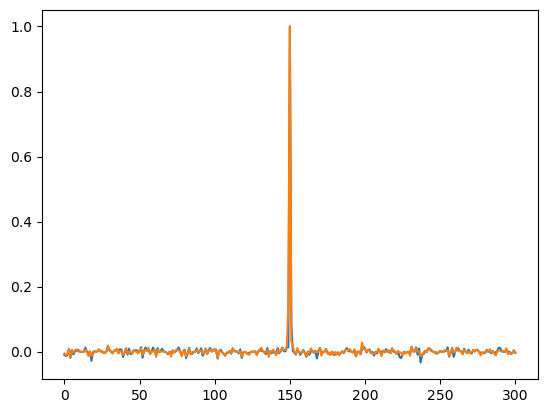

In [12]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])